### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the nbgrader notebook.<br>
When calculating the final score shown to learners, the programming assignment takes the percentage of earned points vs. the total points provided by nbgrader and returns a score matching the equivalent percentage of the point value for the programming assignment.<br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** The autograder will not work properly if your change the variable or method signatures. 

### WARNING
Please refrain from using **print statements/anything that dumps large outputs(>500 lines) to STDOUT** to avoid running to into **memory issues**. 
Doing so requires your entire lab to be reset which may also result in loss of progress and you will be required to reach out to Coursera for assistance with this.
This process usually takes time causing delays to your submission.

### Validate Button
Please note that this assignment uses nbgrader to facilitate grading. You will see a **validate button** at the top of your Jupyter notebook. If you hit this button, it will run tests cases for the lab that aren't hidden. It is good to use the validate button before submitting the lab. Do know that the labs in the course contain hidden test cases. The validate button will not let you know whether these test cases pass. After submitting your lab, you can see more information about these hidden test cases in the Grader Output. <br>
***Cells with longer execution times will cause the validate button to time out and freeze. Please know that if you run into Validate time-outs, it will not affect the final submission grading.*** <br>

# Homework 6: Support Vector Machines 
***

In this assignment we'll explore the details of the Soft-Margin SVM and look at how the choice of tuning parameters  affects the learned models.  We'll also look at kernel SVMs for non-linearly separable and methods for choosing and visualizing good hyperparameters.   

**Note**: Below are some helper functions which are used throughout this notebook.  Execute these before continuing. Do not modify.

In [30]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

def linear_plot(X, y, w=None, b=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)
    
def part2data():
    
    np.random.seed(1239)
    
    X = np.zeros((22,2))
    X[0:10,0]  = 1.5*np.random.rand(10) 
    X[0:10,1]  = 1.5*np.random.rand(10)
    X[10:20,0] = 1.5*np.random.rand(10) +  1.75
    X[10:20,1] = 1.5*np.random.rand(10) +  1
    X[20,0] = 1.5
    X[20,1] = 2.25
    X[21,0] = 1.6
    X[21,1] = 0.25
    
    y = np.ones(22)
    y[10:20] = -1 
    y[20] = 1
    y[21] = -1
    
    return X, y

def part3data(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.50,1.50])
    ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)
    

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

### Part 1: SVM [20 pts, Peer Review]

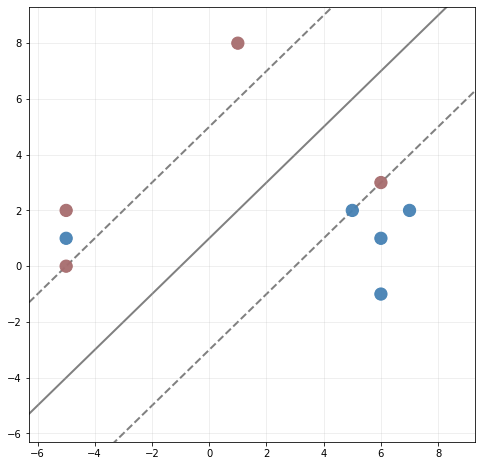

In [31]:
import numpy as np

# Data and Labels 
X = np.array([[1,8],[7,2],[6,-1],[-5,0], [-5,1], [-5,2],[6,3],[6,1],[5,2]])
y = np.array([1,-1,-1,1,-1,1,1,-1,-1])

# Support vector parameters 
w, b = np.array([-1/4, 1/4]), -1/4

# Plot the data and support vector boundaries 
linear_plot(X, y, w=w, b=b)

**Part A [5 pts]**: What is the margin of this particular SVM? 

In [62]:
margin = 0 # update margin to be a correct number

# your code here
import numpy as np

margin = 1/np.linalg.norm(w)
print("M = {:.3f}".format(margin))

M = 2.828


In [60]:
# tests that margin was updated correctly

**Part B [5 pts, Peer Review]**: Which training examples are the support vectors? Assign the coordinate in the list. e.g. support_vectors = [(1,0),(0,0)]

In [33]:
# uncomment and update support_vectors  
# your code here
import numpy as np

# Data and Labels
X = np.array([[1, 8], [7, 2], [6, -1], [-5, 0], [-5, 1], [-5, 2], [6, 3], [6, 1], [5, 2]])
y = np.array([1, -1, -1, 1, -1, 1, 1, -1, -1])

# Support vector parameters
w, b = np.array([-1/4, 1/4]), -1/4

# Initialize a list to store support vectors
support_vectors = []

# Calculate the signed margin for each data point
for i in range(len(X)):
    signed_margin = y[i] * (np.dot(w, X[i]) + b)
    
    # Check if the signed margin is equal to 1 or less than 1
    if signed_margin == 1 or signed_margin < 1:
        support_vectors.append(tuple(X[i]))

# Print the support vectors
print("Support Vectors:", support_vectors)

# support_vectors=[(1,0),(0,0)] 

Support Vectors: [(-5, 0), (-5, 1), (6, 3), (5, 2)]


In [6]:
# tests support_vectors

Answer the following question in this week's **Peer Review assignment**:<br> 
Explain your answer for which training examples are support vectors. For the support vectors that you have identified, which are the in-bound support vectors and which are the out-bound support vectors? 

In [34]:
# instructor testing cell 
# your code here
# Initialize a list to store support vectors
support_vectors = []

# Calculate the signed margin for each data point
for i in range(len(X)):
    signed_margin = y[i] * (np.dot(w, X[i]) + b)
    
    # Check if the signed margin is equal to 1 (In-Bound) or less than 1 (Out-Bound)
    if signed_margin == 1:
        support_vectors.append(("In-Bound", tuple(X[i])))
    elif signed_margin < 1:
        support_vectors.append(("Out-Bound", tuple(X[i])))

# Print the support vectors and their classification
for sv in support_vectors:
    classification, coordinates = sv
    print(f"{coordinates} is an {classification} Support Vector.")


(-5, 0) is an In-Bound Support Vector.
(-5, 1) is an Out-Bound Support Vector.
(6, 3) is an Out-Bound Support Vector.
(5, 2) is an In-Bound Support Vector.


**Part C [5 pts, Peer Review]**: Which training examples have nonzero slack? List their coordinates.

In [50]:
# Initialize a list to store the coordinates of training examples with nonzero slack
nonzero_slack = []

# Calculate the signed margin for each data point
for i in range(len(X)):
    signed_margin = y[i] * (np.dot(w, X[i]) + b)
    
    # Check if the signed margin is less than 1 (Out-Bound)
    if signed_margin < 1:
        nonzero_slack.append(tuple(X[i]))

# Print the coordinates of training examples with nonzero slack
print("Training examples with nonzero slack:", nonzero_slack)


Training examples with nonzero slack: [(-0.5675155375666198, -0.317090262891632), (1.039948348060723, -0.43534917055432276), (-0.03106359571685699, -0.6067010209895471), (0.8834501270682256, -0.6131331597568372), (0.6211602351814318, -0.5955806069807665), (1.0311120852733517, -0.6618966148864617), (0.44294437768371153, -0.7436190939451844), (-0.10853260210113, -0.41045114938963334), (0.0395899933276035, -0.14225180975787174), (0.2684302401911589, -0.4401362531589557), (-0.1486306758249194, 0.11145629702403578), (0.8588382538666506, -0.6086157670299722), (-0.10052820333560109, -0.4410384043662018), (-0.4604013046141988, -0.5580004303246959), (-0.8762339423340495, -0.5380735866027183), (0.5815659396648695, -0.3309646834164006), (-0.20234788779676124, -0.5417728718871442), (0.3750552948388945, -0.49287824989470114), (-0.7271424578721917, -0.5825631878931168), (0.4626561902075925, -0.3576691853141464), (0.9192716502156102, -0.7451992275676119), (-0.1719370294442109, -0.6009016783241776), (

In [51]:
# tests nonzero_slack list 

Answer the following question in this week's **Peer Review assignment**: <br>
How did you know which training examples had nonzero slack? 

In [36]:
# instructor testing cell
# your code here
slack = max(0, 1 - y[i] * (np.dot(w, X[i]) + b))


**Part D [5 pts, Peer Review]**: Compute the slack $\xi_i$ associated with the misclassified points. 

Slack Formula:
#### ξ<sub>i</sub> = 1 −  y<sub>i</sub> ( w<sup>T</sup> x<sub>i</sub>  + b )


In [37]:
# your code here
import numpy as np

# Data and Labels
X = np.array([[1, 8], [7, 2], [6, -1], [-5, 0], [-5, 1], [-5, 2], [6, 3], [6, 1], [5, 2]])
y = np.array([1, -1, -1, 1, -1, 1, 1, -1, -1])

# Support vector parameters
w = np.array([-1/4, 1/4])
b = -1/4

# Initialize a list to store slack computations
slacks = []

# Calculate slack for each data point
for i in range(len(X)):
    # Calculate the signed margin for the data point
    signed_margin = y[i] * (np.dot(w, X[i]) + b)
    
    # Calculate the slack
    slack = 1 - signed_margin
    
    # Check if the data point is misclassified (slack ξi > 0)
    if slack > 0:
        slacks.append(slack)

# Print the list of slack computations


# compute the slack associated with the misclassified points
# return a list slacks with the slack computations
# slacks = [slack1, slack2]
# slack1 = 
# slack2 = 
print(slacks)

[2.25, 2.0]


In [12]:
# tests slacks

Answer the following question in your **Peer Review assignment for the week**: <br>
Do these slack values agree with the plot of the data and the support vector boundaries? 

### Part 2: The Margin vs Slack 
***

In this problem we'll figure out how to fit linear SVM models to data using sklearn.  Consider the data shown below.

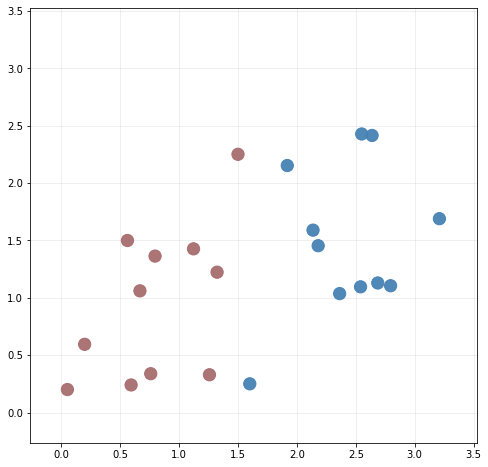

In [38]:
X, y = part2data()
linear_plot(X, y)

**Part A [5 pts]**: Let's fit a linear Soft-Margin SVM to the data above. For SVMs with a linear kernel we'll use the [`LinearSVM`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) method from sklearn's `svm` module.  Go now and look at the documentation. 

Recall that the primal objective function for the linear kernel SVM is as follows 


$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i^p.
$$
**Note that the C parameter definition in sklearn is different from the textbook.**

The two optional parameters in `LinearSVM` that we'll be most concerned with are `C`, the hyperparameter weighting the slackness contribution to the primal objective function, and `loss`, which determines the exponent on the slack variables in the sum. When $p=1$ from above equation, the loss is hinge loss, whereas is $p=2$, it's $L2$ form, the loss is called squared-hinge.

Write some code below to train a linear SVM with $C=1$ and $p=1$, get the computed weight vector and bias, and the plot the resulting model. 

Weight vector (w): [-1.41897528  0.30584252]
Bias (b): [1.76759606]


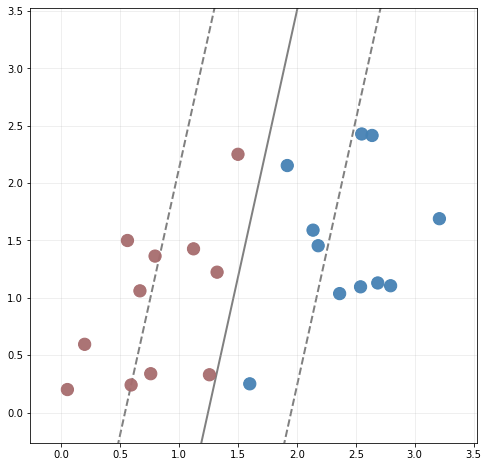

In [39]:
from sklearn.svm import LinearSVC

# TODO: Build a LinearSVC model called lsvm. Train the model and get the parameters, pay attention to the loss parameter
lsvm = LinearSVC(C=1, loss="hinge")  # You can specify C and loss here
lsvm.fit(X, y)  # Fit the model to the data

# Get the parameters
w = lsvm.coef_[0]
b = lsvm.intercept_

# Print the parameters
print("Weight vector (w):", w)
print("Bias (b):", b)

# Plot the resulting model
linear_plot(X, y, w=w, b=b)
plt.show()


In [15]:
# tests w and b 

**Part B**: Experiment with different values of `C`.  Answer the following question in your Peer Review for the week: How does the choice of `C` affect the nature of the decision boundary and the associated margin? 

Experimenting with C=0.001


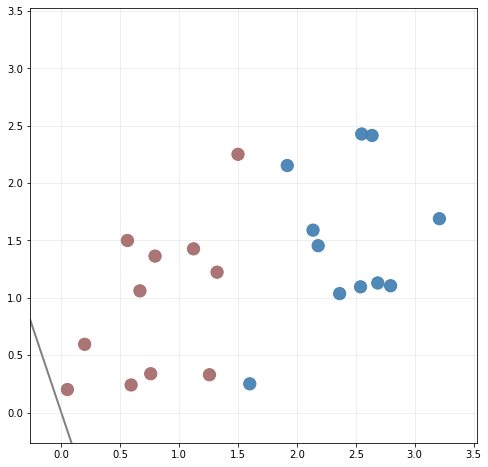

Experimenting with C=0.01


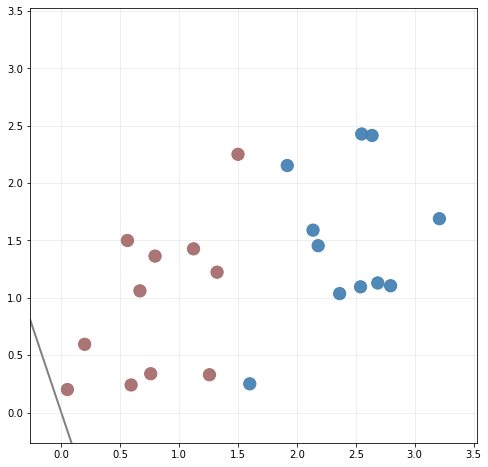

Experimenting with C=0.1


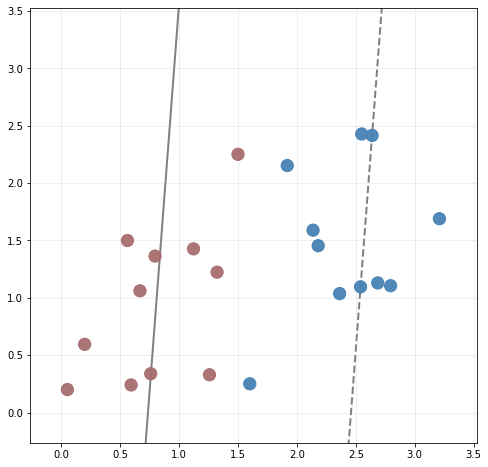

Experimenting with C=1


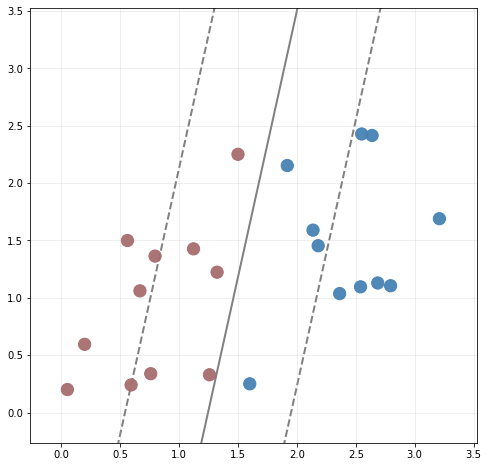

Experimenting with C=10


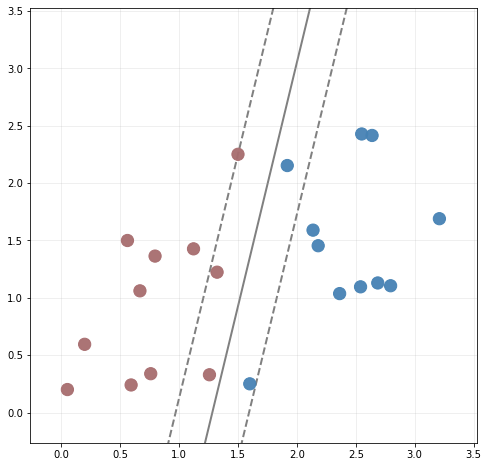

In [40]:
from sklearn.svm import LinearSVC

# TODO: Change the svm model parameter and plot the result.

# your code here



# Define a list of different C values to experiment with
C_values = [0.001, 0.01, 0.1, 1, 10]

# Iterate over the C values and plot the results
for C in C_values:
    # Create a LinearSVC model with the current C value
    lsvm = LinearSVC(C=C, loss="hinge")
    
    # Train the model on the data
    lsvm.fit(X, y)
    
    # Get the parameters
    w = lsvm.coef_[0]
    b = lsvm.intercept_
    
    # Print the C value
    print(f"Experimenting with C={C}")
    
    # Plot the resulting model
    linear_plot(X, y, w=w, b=b)
    plt.show()


**Part C**: Set `C=3` and compare the results you get when using the `hinge` vs the `squared_hinge` values for the `loss` parameter.  In this week's Peer Review Assignment: Explain your observations. Compare hinge loss vs. squared hinge loss.  

Using Hinge Loss:


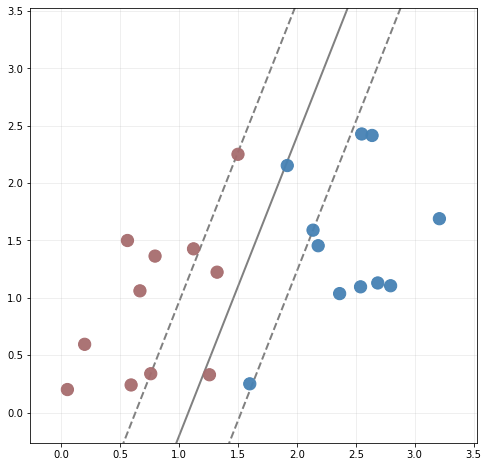

Using Squared_hinge Loss:


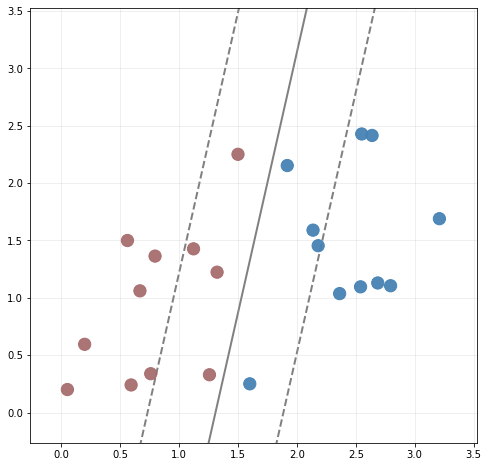

In [41]:
from sklearn.svm import LinearSVC

# TODO: Train the model and get the parameters, pay attention to the loss parameter
# your code here

from sklearn.svm import LinearSVC

# Set C and loss values
C = 3
loss_values = ["hinge", "squared_hinge"]

# Iterate over loss functions and compare the results
for loss in loss_values:
    # Create a LinearSVC model with the specified C and loss
    lsvm = LinearSVC(C=C, loss=loss)
    
    # Train the model on the data
    lsvm.fit(X, y)
    
    # Get the parameters
    w = lsvm.coef_[0]
    b = lsvm.intercept_
    
    # Print the loss function used
    print(f"Using {loss.capitalize()} Loss:")
    
    # Plot the resulting model
    linear_plot(X, y, w=w, b=b)
    plt.show()



**Part D**: In general, how does the choice of `C` affect the bias and variance of the model? Write your answer in this week's Peer Review assignment. 

In [42]:

# testing cell
# your code here

# Explain how the choice of C affects the bias and variance of the model
bias_variance_explanation = """
The choice of the hyperparameter C in a Support Vector Machine (SVM) significantly affects the bias and variance of the model:

1. Low C (High Regularization):
   - High Bias, Low Variance: When C is set to a small value, the SVM imposes a high degree of regularization on the model. It prioritizes a larger margin even if it means allowing some misclassified points (outliers). This leads to a simpler decision boundary.
   - High Bias: The model may underfit the data, as it might not capture the data's complexity, resulting in a high bias.

2. High C (Low Regularization):
   - Low Bias, High Variance: When C is set to a large value, the SVM imposes less regularization on the model. It prioritizes correctly classifying as many data points as possible, potentially at the cost of a smaller margin.
   - Low Bias: The model is more complex and closely fits the data points, including some that might be considered outliers. This can result in a lower bias.
   - High Variance: The model may overfit the data, as it might fit the noise in the data, leading to a high variance.

In summary, the choice of C in an SVM acts as a regularization parameter that balances the trade-off between maximizing the margin (bias) and minimizing the classification error (variance). Lower values of C increase bias and reduce variance, leading to a simpler model with a wider margin. Higher values of C decrease bias and increase variance, leading to a more complex model that closely fits the data. The specific choice of C should be based on the problem's characteristics, requiring a careful trade-off between bias and variance through techniques like cross-validation.
"""

# Print the explanation
print(bias_variance_explanation)



The choice of the hyperparameter C in a Support Vector Machine (SVM) significantly affects the bias and variance of the model:

1. Low C (High Regularization):
   - High Bias, Low Variance: When C is set to a small value, the SVM imposes a high degree of regularization on the model. It prioritizes a larger margin even if it means allowing some misclassified points (outliers). This leads to a simpler decision boundary.
   - High Bias: The model may underfit the data, as it might not capture the data's complexity, resulting in a high bias.

2. High C (Low Regularization):
   - Low Bias, High Variance: When C is set to a large value, the SVM imposes less regularization on the model. It prioritizes correctly classifying as many data points as possible, potentially at the cost of a smaller margin.
   - Low Bias: The model is more complex and closely fits the data points, including some that might be considered outliers. This can result in a lower bias.
   - High Variance: The model may ove

### Part 3: Nonlinear SVM, Parameter Tuning, Accuracy, and Cross-Validation 
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ associated with the slack variables in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^d$ you have to select the shift $c$ and the polynomial degree $d$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data

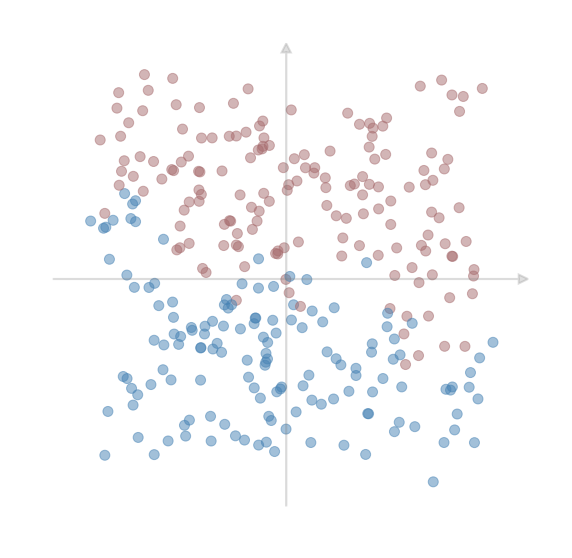

In [45]:
X, y = part3data(N=300, seed=1235)
nonlinear_plot(X, y)

**Part A**: We can use the method [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from sklearn's `svm` module to fit an SVM with a nonlinear kernel to the data.  Go now and look at the documentation. Note that we pass the `kernel="rbr"` parameter to use the RBF kernel.  The other two parameters we'll be concerned with are `C` and the RBF parameter `gamma`.   

Write some code to fit an SVM with RBF kernel to the data and plot the results.  Use the parameter values `C=1` and `gamma=1`.

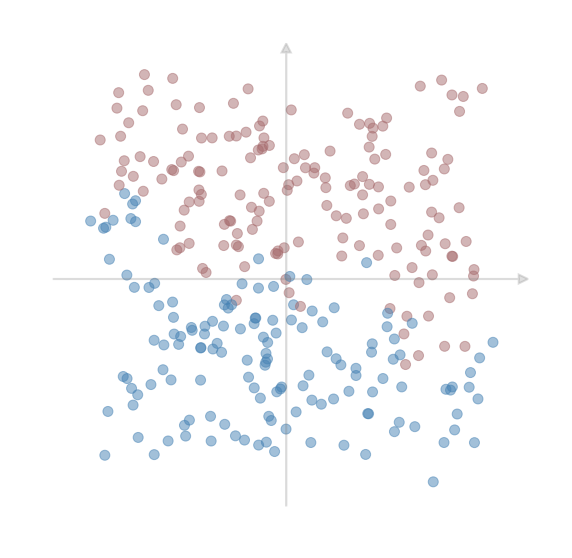

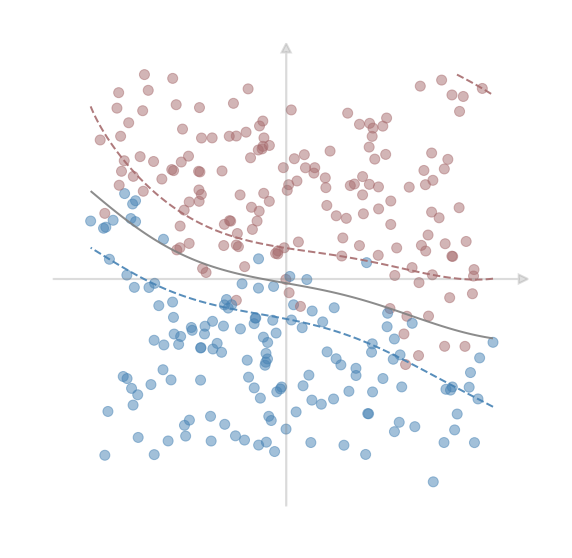

In [20]:
from sklearn.svm import SVC

nlsvm= None
# your code here

# Generate and visualize the two-dimensional data
X, y = part3data(N=300, seed=1235)
nonlinear_plot(X, y)

# Set the SVM parameters
C = 1
gamma = 1

# Create an SVM model with RBF kernel
nlsvm = SVC(kernel='rbf', C=C, gamma=gamma)

# Train the model on the data
nlsvm.fit(X, y)

# Plot the resulting model
nonlinear_plot(X, y, nlsvm)



**Part B**: In this part we'll use cross-validation to estimate the validation accuracy achieved by our model.  Experiment with the values of the hyperparameters to see if you can get a good validation accuracy. How do the choice of `C` and `gamma` affect the resulting decision boundary? Write your response in this week's Peer Review assignment. 

C=0.01, gamma=0.01, Mean Accuracy: 0.5266666666666666
C=0.01, gamma=0.1, Mean Accuracy: 0.5266666666666666
C=0.01, gamma=1, Mean Accuracy: 0.5266666666666666
C=0.01, gamma=10, Mean Accuracy: 0.5266666666666666
C=0.1, gamma=0.01, Mean Accuracy: 0.5266666666666666
C=0.1, gamma=0.1, Mean Accuracy: 0.9166666666666666
C=0.1, gamma=1, Mean Accuracy: 0.9033333333333333
C=0.1, gamma=10, Mean Accuracy: 0.9299999999999999
C=1, gamma=0.01, Mean Accuracy: 0.9133333333333333
C=1, gamma=0.1, Mean Accuracy: 0.9066666666666666
C=1, gamma=1, Mean Accuracy: 0.9199999999999999
C=1, gamma=10, Mean Accuracy: 0.9366666666666665
C=10, gamma=0.01, Mean Accuracy: 0.9033333333333333
C=10, gamma=0.1, Mean Accuracy: 0.9133333333333333
C=10, gamma=1, Mean Accuracy: 0.9333333333333332
C=10, gamma=10, Mean Accuracy: 0.9433333333333334
Best C: 10
Best gamma: 10
Best Mean Accuracy: 0.9433333333333334
Cross-Val Mean Accuracy (Final Model): 0.943


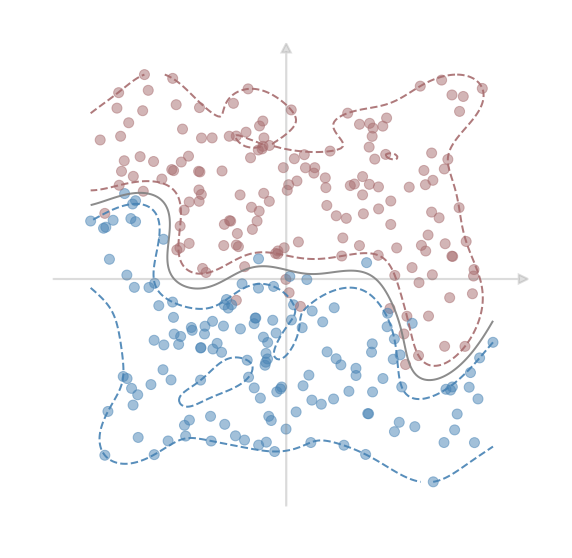

In [23]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Generate the two-dimensional data
X, y = part3data(N=300, seed=1235)

# Define a range of values for C and gamma to experiment with
C_values = [0.01, 0.1, 1, 10]
gamma_values = [0.01, 0.1, 1, 10]

# Initialize variables to store the best parameters and accuracy
best_accuracy = 0
best_C = None
best_gamma = None

# Perform cross-validation (e.g., 5-fold)
for C in C_values:
    for gamma in gamma_values:
        # Create an SVM model with RBF kernel for the current C and gamma
        nlsvm = SVC(kernel='rbf', C=C, gamma=gamma)
        
        # Perform cross-validation (e.g., 5-fold)
        scores = cross_val_score(nlsvm, X, y, cv=5)
        
        # Calculate the mean accuracy across cross-validation folds
        mean_accuracy = np.mean(scores)
        
        # Print the current hyperparameters and accuracy
        print(f"C={C}, gamma={gamma}, Mean Accuracy: {mean_accuracy}")
        
        # Check if this combination achieved the best accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_C = C
            best_gamma = gamma

# Print the best hyperparameters and accuracy
print(f"Best C: {best_C}")
print(f"Best gamma: {best_gamma}")
print(f"Best Mean Accuracy: {best_accuracy}")

# Create the final SVM model with the best hyperparameters
final_nlsvm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
final_nlsvm.fit(X, y)

# Print the mean accuracy of the final model
final_scores = cross_val_score(final_nlsvm, X, y, cv=5)
print("Cross-Val Mean Accuracy (Final Model): {:.3f}".format(np.mean(final_scores)))

# Plot the resulting decision boundary
nonlinear_plot(X, y, clf=final_nlsvm)  # Use 'clf' argument instead of 'nlsvm'


**Part C**: How does the choice of **kernel** function affect the bias/variance of the model? Write your answer in this week's Peer Review assignment.   

In [24]:
# instructor testing cell 
# your code here


### Part 4: Automating the Parameter Search 
***

On the previous problem we were able to choose some OK parameters just by hand-tuning.  But in real life (where time is money) it would be better to do something a little more automated.  One common thing to do is a **grid-search** over a predefined range of the parameters.  In this case you will loop over all possible combinations of parameters, estimate the accuracy of your model using K-Folds cross-validation, and then choose the parameter combination that produces the highest validation accuracy. 

**Part A**: Below is an experiment where we search over a logarithmic range between $2^{-5}$ and $2^{5}$ for $C$ and a range between $2^{-5}$ and $2^{5}$ for $\gamma$.  For the accuracy measure we use K-Folds CV with $K=3$.

Best Parameters: {'C': 10.0, 'gamma': 10.0}
Best Mean Accuracy: 0.9433333333333334


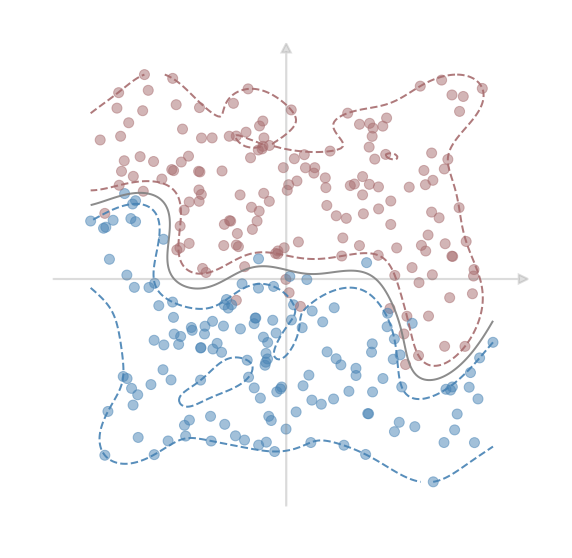

In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV
grid=None # ToDo: replace it to proper GridSearchCV object and run the grid search with cross validation

# your code here
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
import numpy as np

# Generate the two-dimensional data
X, y = part3data(N=300, seed=1235)

# Define the parameter grid to search over
param_grid = {
    'C': np.logspace(-5, 5, 11),  # Range of C values from 2^-5 to 2^5
    'gamma': np.logspace(-5, 5, 11)  # Range of gamma values from 2^-5 to 2^5
}

# Create an SVM model with RBF kernel
svm = SVC(kernel='rbf')

# Create a GridSearchCV object with K-Folds cross-validation (K=3)
grid = GridSearchCV(svm, param_grid, cv=3)

# Fit the grid search to the data
grid.fit(X, y)

# Print the best parameters and corresponding mean accuracy
print("Best Parameters:", grid.best_params_)
print("Best Mean Accuracy:", grid.best_score_)

# Plot the resulting decision boundary using the best parameters
best_svm = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
best_svm.fit(X, y)
nonlinear_plot(X, y, clf=best_svm)


**Part B**: The following function will plot a heat-map of the cross-validation accuracies for each combination of parameters.  Which combination looks the best? Enter your response in this week's Peer Review assignment. 

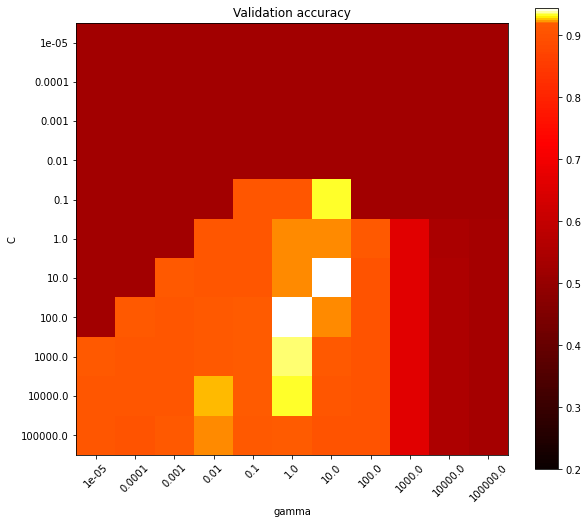

In [26]:
plotSearchGrid(grid)

In [27]:
# instuctor testing cell 
# your code here


**Part C**: The GridSearchCV object scores, among other things, the best combination of parameters as well as the cross-validation accuracy achieved with those parameters.  Print those quantities for our model. 

In [28]:
# print best paramters and best accuracy 
# your code here
# Print best parameters and best accuracy
print("Best Parameters:", grid.best_params_)
print("Best Mean Accuracy:", grid.best_score_)


Best Parameters: {'C': 10.0, 'gamma': 10.0}
Best Mean Accuracy: 0.9433333333333334


**Part D [Peer Review]**: The GridSearchCV object also stores the classifier trained with the best hyperparameters.  Pass this best estimator into the `nonlinear_plot` function to view the best decision boundary. Answer the Peer Review questions for this section. What can you tell about the best decision boundary? 

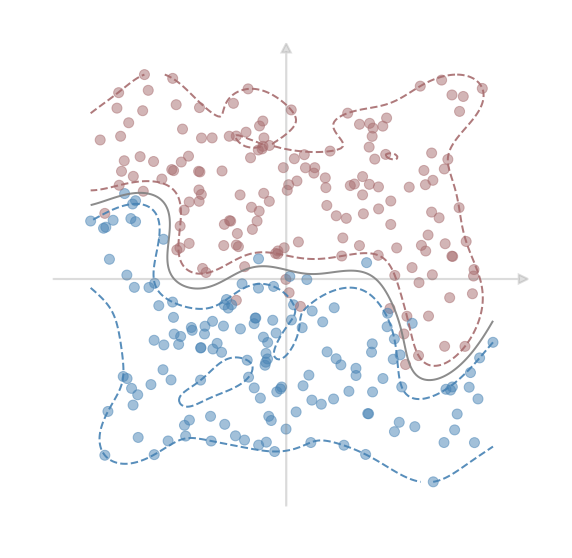

In [29]:
# pass GridSearchCV object best estimator into nonlinear_plot
# your code here
# Get the best estimator from the GridSearchCV object
best_estimator = grid.best_estimator_

# Plot the resulting decision boundary using the best estimator
nonlinear_plot(X, y, clf=best_estimator)
